# Assignment Week 8
Data Augmentation and AE Networks usinng MNIST

In [1]:
#MNIST is a build in Pytorch dataset
from torchvision import datasets as dts
from torchvision.transforms import ToTensor
train = dts.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test = dts.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.39MB/s]


In [2]:
train[0][0].shape

torch.Size([1, 28, 28])

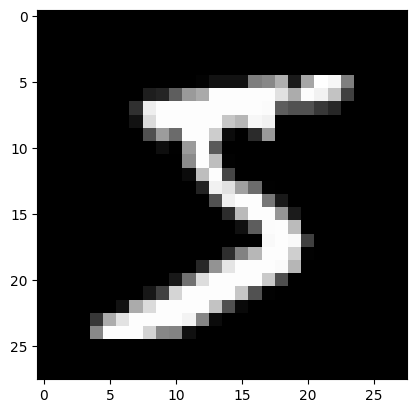

In [3]:
import matplotlib.pyplot as plt
plt.imshow(train[0][0].reshape((28,28)), cmap='gray')

## Exercise 1
Augment the training data with 6 differnet suitable augmentations
* use the PyTorch augmentation framework -> https://pytorch.org/vision/stable/transforms.html
* visualize some examples

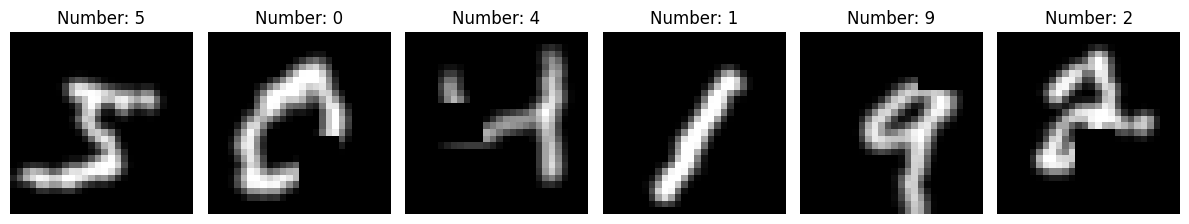

In [27]:
from torchvision.transforms import v2

# Define the augmentation transforms
augmentations = v2.Compose([
    v2.RandomRotation(degrees=15),
    v2.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    v2.RandomAffine(degrees=5, scale=(0.9, 1)),
    v2.GaussianBlur(kernel_size=3),
    v2.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.5, 3)),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
])

# Apply the augmentations to the training data
train_augmented = dts.MNIST(
    root='data',
    train=True,
    transform=v2.Compose([ToTensor(), augmentations]),
    download=True,
)

# Visualize some augmented examples
fig, axes = plt.subplots(1, 6, figsize=(12, 4))
for i in range(6):
    augmented_image, label = train_augmented[i]
    axes[i].imshow(augmented_image.reshape((28, 28)), cmap='gray')
    axes[i].set_title(f"Number: {label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Exercise 2
Build and train a MLP Autoencoder with
* 2 Encoder Layers
* 2 Decoder Layers
* Identity Loss

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


class MLP_Autoencoder(nn.Module):
  def __init__(self):
    super(MLP_Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 128),
        nn.ReLU(True),
        nn.Linear(128, 64),
        nn.ReLU(True)
    )
    self.decoder = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(True),
        nn.Linear(128, 28 * 28),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

model = MLP_Autoencoder()

batch_size = 128
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
num_epochs = 10
for epoch in range(num_epochs):
  for data in train_loader:
    img, _ = data
    img = img.view(img.size(0), -1)
    output = model(img)
    loss = criterion(output, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished.')

Epoch [1/10], Loss: 0.0267
Epoch [2/10], Loss: 0.0169
Epoch [3/10], Loss: 0.0142
Epoch [4/10], Loss: 0.0126
Epoch [5/10], Loss: 0.0107
Epoch [6/10], Loss: 0.0097
Epoch [7/10], Loss: 0.0097
Epoch [8/10], Loss: 0.0091
Epoch [9/10], Loss: 0.0086
Epoch [10/10], Loss: 0.0082
Training finished.


## Exercise 3


Use the Gaussian Noise as augmentation and your AE to remove the noise.
* visualize input and output examples

In [31]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

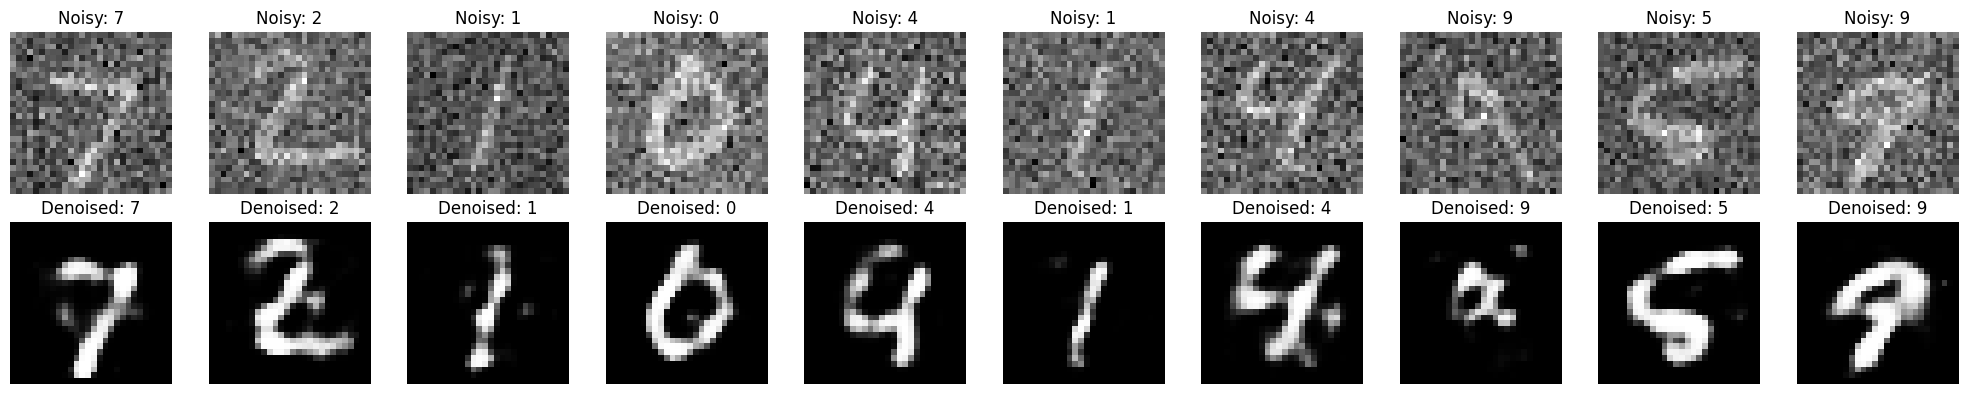

In [40]:
# prompt: Use the Gaussian Noise as augmentation and your AE to remove the noise.
# visualize input and output examples

# dataset with Gaussian noise applied
noise_augment = v2.Compose([
    ToTensor(),
    AddGaussianNoise(std=0.4)
])

test_noisy = dts.MNIST(
    root='data',
    train=False,
    transform=noise_augment,
    download=True,
)

# Visualize noisy and denoised
model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        noisy_image, label = test_noisy[i]
        denoised_image = model(noisy_image.view(1, -1)).view(1, 28, 28)

        # Display noisy
        axes[0, i].imshow(noisy_image.squeeze(), cmap='gray')
        axes[0, i].set_title(f"Noisy: {label}")
        axes[0, i].axis('off')

        # Display denoised
        axes[1, i].imshow(denoised_image.squeeze(), cmap='gray')
        axes[1, i].set_title(f"Denoised: {label}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

## Exercise 4
Clustering: extract the latent space representations of the train data and apply K-Means (fron Scikit-Learn) with k=10. Use the data lables to evaluate the cluter quality.

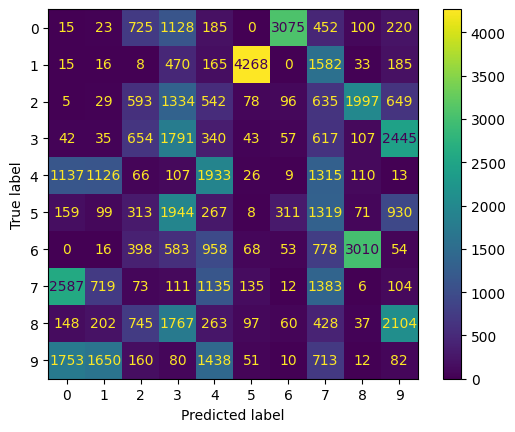

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5923
           1       0.00      0.00      0.00      6742
           2       0.16      0.10      0.12      5958
           3       0.19      0.29      0.23      6131
           4       0.27      0.33      0.30      5842
           5       0.00      0.00      0.00      5421
           6       0.01      0.01      0.01      5918
           7       0.15      0.22      0.18      6265
           8       0.01      0.01      0.01      5851
           9       0.01      0.01      0.01      5949

    accuracy                           0.10     60000
   macro avg       0.08      0.10      0.09     60000
weighted avg       0.08      0.10      0.09     60000



In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Extract latent representations for the training data
model.eval()
latent_representations = []
train_labels = []
with torch.no_grad():
  for data, labels in train_loader:
    img = data.view(data.size(0), -1)
    latent = model.encoder(img)
    latent_representations.append(latent.numpy())
    train_labels.append(labels.numpy())

latent_representations = np.concatenate(latent_representations, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
predict_labels = kmeans.fit_predict(latent_representations)

# Confusionsmatrix
cm = confusion_matrix(train_labels, predict_labels)

unique_predicted_labels = np.unique(predict_labels)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=unique_predicted_labels)
disp.plot()
plt.show()

print(classification_report(train_labels, predict_labels))